# 3 Pre-Processing Data and Training<a id='4_Pre-Processing_and_Training_Data'></a>

## 3.1 Introduction<a id='4.2_Introduction'></a>

In preceding notebooks, we performed preliminary assessments of data quality and refined the question to be answered. We determined that predicting market rent is the primary aim. That market rent can be applied to a Return-on-Investment calculation for each house for sale, determining whether or not that house would make a good investment on some ROI threshold. 

Before we can develop a predictive model, we need to encode categoricals, scale, and reduce dimensionality.

## 3.2 Imports<a id='4.3_Imports'></a>

In [132]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn import tree, metrics
from sklearn.utils import check_array
from io import StringIO
from IPython.display import Image
import pydotplus
import datetime
import math
from numpy import arange
from yellowbrick.regressor import ResidualsPlot

from library.sb_utils import save_file

## 3.3 Load Data<a id='4.4_Load_Data'></a>

In [133]:
corporate_data = pd.read_csv('../data/corporate_properties_values_Demo.csv')
corporate_data.head().T

,0,1,2,3,4
property_code,10000470,10000616,10000695,10000753,10000801
address_1,10265 Quail St,10433 Holland Pl,10545 Hoyt St,10627 Kittredge St,10705 Clermont St
city,Westminster,Westminster,Westminster,Commerce City,Thornton
state,CO,CO,CO,CO,CO
zipcode,80021,80021,80021,80022,80233
beds,3,3,3,3,3
baths,2.0,1.5,2.0,2.5,2.0
sqft,1437,1144,1296,1993,1544
market_rent,2582.0,2199.0,2351.0,2939.0,2529.0
lat,39.8823,39.8825,39.8882,39.88982,39.89058


In [134]:
corporate_data.shape

(259, 22)

In [135]:
sale_data = pd.read_csv('../data/for_sale_Demo.csv')
sale_data.head().T

,0,1,2,3,4
address,19632 W 59th Avenue,2655 Locust Street,3453 Wabash Street,1550 E Dartmouth Avenue,1270 Pontiac Street
city,Golden,Denver,Denver,Englewood,Denver
zip,80403,80207,80238,80113,80220
beds,4.0,5.0,3.0,5.0,4.0
baths,3.0,3.0,4.0,2.0,2.0
sqft,2216,2915,2134,2727,1835
listPrice,750000,750000,750000,750000,750000
taxes,6807,2846,4916,2755,2937
lat,39.804067,39.755696,39.764499,39.660276,39.736881
lng,-105.222061,-104.914396,-104.889523,-104.969208,-104.905484


## 3.4 Manipulate Categorical Data <a id='4.5_Extract_Big_Mountain_Data'></a>

Let's start with the corporate owned properties. 
Because all of the properties are in Colorado, the state column doesn't add any information: let's remove it. The property_code is a unique, discrete piece of information used only by the property owner, with no relationship to the dependent variable, so let's remove that too. 

In [136]:
# Drop uninformative 'state' and 'property_code' columns
corporate_data = corporate_data.drop(['state', 'property_code'], axis=1)

Let's rename a couple of features so they make sense across dataframes. Rename 'estimatedValue' to 'value'. We will do the same on the other dataframe once we begin pre-processing it. 

In [137]:
# Rename two columns in corporate data df
cols = {'estimatedValue':'value'}
corporate_data = corporate_data.rename(columns=cols)

In [138]:
# rename sale_data columns
cols={'zip':'zipcode', 'listPrice':'value'}
sale_data = sale_data.rename(columns=cols)

The 'city' column doesn't add any information. Instead, let's use some information to categorize the cities by household income. Data for 2019 is available on the US Census site. Import that data, add to both the corporate_data and sale_data records, and we will set aside the city column before doing the test/train split. 

Additionally, the *name* of the district doesn't add any information. For each district, we have already gathered some information on the school lunch program (an indicator of poverty in the community), the rank of the schools within the district, and the racial demographics.

In [139]:
income = pd.read_csv('../data/City income.csv')
income_T = income.T

In [140]:
# manipulate income information to make compatible with a pd.concat
new_header = income_T.iloc[0] 
# take the rest of the data minus the header row
income_T = income_T[1:] 
# set the header row as the df header
income_T.columns = new_header 
income_T.rename(columns = {'Fact ':'City'}, inplace = True)

In [141]:
income_T.columns

Index(['Median household income (in 2019 dollars), 2015-2019', 'Per capita income in past 12 months (in 2019 dollars), 2015-2019'], dtype='object', name='Fact')

In [142]:
income_T.drop(['Per capita income in past 12 months (in 2019 dollars), 2015-2019'], axis=1, inplace=True)

In [143]:
# Let's see if there are any towns in the corporate_data set which are not included in the income data. 
no_data = corporate_data[~corporate_data['city'].isin(income_T.index)]
no_data.head()

,address_1,city,zipcode,beds,baths,sqft,market_rent,lat,lng,districtMatch,estimatedPrice,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement
11,11375 Nome St,Henderson,80640,4,2.0,2087,2595.0,39.90208,-104.85186,Brighton 27J School District,495000.00,44.03,2.20,2.92,53.74,0.31,0.17,3.00,37.65,-48.06
89,11620 Oakland Dr,Henderson,80640,3,1.5,1420,2300.0,39.90825,-104.84968,Brighton 27J School District,376666.67,44.03,2.20,2.92,53.74,0.31,0.17,3.00,37.65,-48.06
143,11798 W Marlowe Ave,Morrison,80465,4,2.5,2404,2900.0,39.63200,-105.12900,Jefferson County R-1 School District,429937.50,37.16,1.45,2.89,26.14,0.62,0.14,4.07,64.70,-23.29
144,11798 W Marlowe Ave,Morrison,80465,4,2.5,2404,2933.0,39.63200,-105.12900,Jefferson County R-1 School District,405000.00,37.16,1.45,2.89,26.14,0.62,0.14,4.07,64.70,-23.29


The houses in Henderson are actually in Commerce City. This is a quirk of Denver-metro addresses. Morrison is a tiny area, so there isn't any data available for it. The closest town to Morrison is Golden. Let's map these in both the corporate and sales data. 

In [144]:
dict1 = {'Henderson':'Commerce City', 'Morrison':'Golden'}
corporate_data.loc[corporate_data['city'].isin(dict1.keys()), 'city'] = corporate_data['city'].map(dict1)

In [145]:
# Let's see if there is any sales data that doesn't have income information. 
no_data = sale_data[~sale_data['city'].isin(income_T.index)]

In [146]:
no_data['city'].unique()

array(['Morrison'], dtype=object)

All of these little hamlets are near Golden, so let's map them to Golden. 

In [147]:
dict2={'Morrison':'Golden', 'Indian Hills':'Golden', 'Idledale':'Golden'}
sale_data.loc[sale_data['city'].isin(dict1.keys()), 'city'] = sale_data['city'].map(dict1)

In [148]:
corporate_data_I = corporate_data.merge(income_T, left_on='city', right_on=income_T.index)
corporate_data_I.shape, corporate_data.shape

((259, 21), (259, 20))

In [149]:
sale_data_I = sale_data.merge(income_T, left_on='city', right_on=income_T.index)

'Beds' and 'baths' should be categorical columns, since these are inherently categorical. Change the data types of these columns.

We can see that the data for sale includes 2, 3, 4, 5, 6 and 7 bedroom houses. The bathrooms count 2, 3, 4, and 7! The corporate data includes 1, 2, 3, and 4 bathroom properties, and bedrooms from 3 to 5. The corporate entity does not invest in 2 bedroom houses, according to our data. The investor also make a distinction between half baths and baths that our sales data does not appear to make. Let's go back to the data and change all the half baths to integers (round up), and remove the data from the sales of any bedroom count below 3 or over 5, and bathrooms below 2 and more than 4. If written correctly, this modification will allow us to scale our model to all sorts of sales data and weird counts of beds and baths. 

In [150]:
# check counts of bedrooms and bathrooms; needs to be consistent.
corporate_data_I['beds'].unique(), sale_data_I['beds'].unique()

(array([3, 4, 2, 5], dtype=int64), array([4., 5., 3., 2., 7., 6., 9., 1.]))

In [151]:
# check counts of bedrooms and bathrooms; needs to be consistent.
corporate_data_I['baths'].unique(), sale_data_I['baths'].unique()

(array([2.  , 1.5 , 3.  , 2.5 , 3.5 , 1.  , 2.25, 4.  ]),
 array([3., 1., 2., 4., 5.]))

In [152]:

# change count of bathrooms to integers
corporate_data_I['baths'] = corporate_data_I['baths'].apply(np.ceil)

In [153]:
# change data types
corporate_data_I['beds'] = corporate_data_I['beds'].astype(int)
corporate_data_I['baths'] = corporate_data_I['baths'].astype(int)
sale_data_I['baths'] = sale_data_I['baths'].astype(int)
sale_data_I['beds'] = sale_data_I['beds'].astype(int)

In [154]:
# identify unique bathroom counts in corporate properties
corporate_data_I['baths'].unique()

array([2, 3, 4, 1])

In [155]:
# How many bedrooms does the corporate investor prefer?
corporate_data_I['beds'].unique()

array([3, 4, 2, 5])

In [156]:
# Drop NaN sales data and sales where bathroom count is not in [1, 2, 3, 4]
sale_data_I.dropna(inplace=True)
#define values
bath_values = [1, 2, 3, 4]
bed_values = [2, 3, 4, 5]
#drop rows that contain any value in the list
sale_data_I = sale_data_I[sale_data_I.baths.isin(bath_values) == True]
sale_data_I = sale_data_I[sale_data_I.beds.isin(bed_values) == True]

In [157]:
# We started with 666 sales listings, what do we have after considering the restrictions of modeling?
sale_data_I.shape

(586, 22)

After making sure that the sales data information will meet the requirements of the model, we still have a lot of listings. The properties that did not meet the apparent requirements of the corporate investor did not make up many of the dataset (about 5%). 

In [158]:
# change data to categorical type
corporate_data_I['beds'] = pd.Categorical(corporate_data_I.beds)
corporate_data_I['baths'] = pd.Categorical(corporate_data_I.baths)
sale_data_I['beds'] = pd.Categorical(sale_data_I.beds)
sale_data_I['baths'] = pd.Categorical(sale_data_I.baths)

In [159]:
# Encode categorical features with dummies, dropping one to avoid instability
dummy_features_corp = pd.get_dummies(corporate_data_I[['beds', 'baths']], drop_first=True)
dummy_features_sale = pd.get_dummies(sale_data_I[['beds', 'baths']], drop_first=True)

# Concat dummy_features to original dfs
corporate_data_I = pd.concat([corporate_data_I, dummy_features_corp], axis=1)
sale_data_I = pd.concat([sale_data_I, dummy_features_sale], axis=1)

In [160]:
sale_data_I.columns, corporate_data_I.columns

(Index(['address', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'value', 'taxes',
        'lat', 'lng', 'monthly_hoa', 'districtMatch', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement',
        'Median household income (in 2019 dollars), 2015-2019', 'beds_3',
        'beds_4', 'beds_5', 'baths_2', 'baths_3', 'baths_4'],
       dtype='object'),
 Index(['address_1', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'market_rent',
        'lat', 'lng', 'districtMatch', 'estimatedPrice', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovemen

In [161]:
# rename address_1 to address, and estimatedPrice to value
corporate_data_I.rename(columns = {'address_1':'address', 'estimatedPrice':'value'}, inplace = True)

In [162]:
# Check datatype of new column
corporate_data_I['Median household income (in 2019 dollars), 2015-2019'].dtypes

dtype('O')

In [163]:
corporate_data_I.columns, sale_data_I.columns

(Index(['address', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'market_rent',
        'lat', 'lng', 'districtMatch', 'value', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement',
        'Median household income (in 2019 dollars), 2015-2019', 'beds_3',
        'beds_4', 'beds_5', 'baths_2', 'baths_3', 'baths_4'],
       dtype='object'),
 Index(['address', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'value', 'taxes',
        'lat', 'lng', 'monthly_hoa', 'districtMatch', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement',
       

In [164]:
corporate_data_I[['Median household income (in 2019 dollars), 2015-2019']] = \
        corporate_data_I[['Median household income (in 2019 dollars), 2015-2019']].replace('[\$,]','',regex=True).astype(float)

In [165]:
sale_data_I[['Median household income (in 2019 dollars), 2015-2019']] = \
        sale_data_I[['Median household income (in 2019 dollars), 2015-2019']].replace('[\$,]','',regex=True).astype(float)

In [166]:
# Write the combined dataframe to a new csv
corporate_data_I.to_csv('../data/corporate_data_I.csv', index = False, header = True)
sale_data_I.to_csv('../data/sale_data_I.csv', index = False, header = True)

## 3.5 Train/Test Split<a id='4.6_Train/Test_Split'></a>

After a couple of preliminary models, it seems that the 'value' of a property is tied to other features, possible some of which we have included in our particular set of features. 
First, we will run machine learning models including the feature 'value', then run without, and see which gives us a better outcome (explains more of the variability in data). 

So, let's use a 90/10 train/test split within the corporate data, using 'market_rent' as the dependent variable. 

In [167]:
# use train_test_split 
X_train, X_test, y_train, y_test = train_test_split(corporate_data_I.drop(columns='market_rent'), 
                                                    corporate_data_I.market_rent, test_size=0.05, 
                                                    random_state=42)

In [168]:
X_train.shape, X_test.shape

((246, 26), (13, 26))

In [169]:
y_train.shape, y_test.shape

((246,), (13,))

In [170]:
#Save the 'address' and 'zipcode' columns from the train/test data into address_train
# and address_train
#Then drop those columns from `X_train` and `X_test`. Use 'inplace=True'
drop_columns = ['address', 'zipcode', 'lat', 'lng', 'districtMatch', 'city', 'beds', 'baths', 'value']
dropped_train = X_train[drop_columns]
dropped_test = X_test[drop_columns]
X_train.drop(columns=drop_columns, inplace=True)
X_test.drop(columns=drop_columns, inplace=True)
X_train.shape, X_test.shape

((246, 17), (13, 17))

In [171]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

sqft                                                      int64
percentFreeDiscLunch                                    float64
percentofAfricanAmericanStudents                        float64
percentofAsianStudents                                  float64
percentofHispanicStudents                               float64
percentofIndianStudents                                 float64
percentofPacificIslanderStudents                        float64
percentofTwoOrMoreRaceStudents                          float64
percentofWhiteStudents                                  float64
rankMovement                                            float64
Median household income (in 2019 dollars), 2015-2019    float64
beds_3                                                    uint8
beds_4                                                    uint8
beds_5                                                    uint8
baths_2                                                   uint8
baths_3                                 

In [172]:
#Repeat this check for the test split in `X_test`
X_test.dtypes

sqft                                                      int64
percentFreeDiscLunch                                    float64
percentofAfricanAmericanStudents                        float64
percentofAsianStudents                                  float64
percentofHispanicStudents                               float64
percentofIndianStudents                                 float64
percentofPacificIslanderStudents                        float64
percentofTwoOrMoreRaceStudents                          float64
percentofWhiteStudents                                  float64
rankMovement                                            float64
Median household income (in 2019 dollars), 2015-2019    float64
beds_3                                                    uint8
beds_4                                                    uint8
beds_5                                                    uint8
baths_2                                                   uint8
baths_3                                 

All features in X are numeric.

## 3.6 Check Data Distributions <a id='3.6 Check Data Distributions'></a>

 Let's look at the distributions of the training data. 

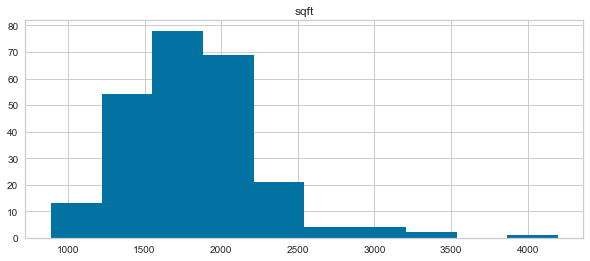

In [173]:
X_train[['sqft']].hist(figsize=(10,4))
plt.show()

Graphically, it looks like there are a couple on the end - but these may not be outliers really, but rather large houses that are worth a lot of money. More data may prove these to be not outliers at all. We believe that there are more houses in the smaller, less expensive range and fewer in the larger, more expensive range *in general* and that houses smaller than about 1000 square feet are quite rare, leading to this distribution. 
We choose to not trim these data points as they are representative of the pattern as a whole. 

## 3.7 Initial Modeling - Dummy Regressor

First, let's try the most basic model - the mean. This will give us some basis for comparison of the rest of the work we do. 

In [174]:
# Fit the Dummy Regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[2553.48780488]])

In [175]:
# Predict outcome on X_train
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([2553.48780488, 2553.48780488, 2553.48780488, 2553.48780488,
       2553.48780488])

In [176]:
# Predict outcome on X_test
y_te_pred = dumb_reg.predict(X_test)
y_te_pred[:5]

array([2553.48780488, 2553.48780488, 2553.48780488, 2553.48780488,
       2553.48780488])

Let's start a list of models and MAE on the test set for some comparison. 

In [177]:
models = []
mae_test = []
mae_train = []
r2_test = []
r2_train = []
MAPE_test = []
MAPE_train = []
models.append(('DR', dumb_reg))

### 3.7.1 Metrics on Dummy Regressor<a id='4.7.1_Metrics'></a>

#### 3.7.1.1 R-squared, or coefficient of determination of Dummy Model<a id='4.7.1.1_R-squared,_or_coefficient_of_determination'></a>

The R-squared of the dummy regressor should be 0 by definition. It will not be zero for the test set. 

In [178]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0722490818722541)

#### 3.7.1.2 Mean Absolute Error of Dummy Model<a id='4.7.1.1_R-squared,_or_coefficient_of_determination'></a>

As a reminder, the mean absolute error is the average of the absolute errors. 

In [179]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(183.17826690462027, 194.65103189493433)

In [180]:
mae_test.append(mean_absolute_error(y_test, y_te_pred))
r2_test.append(r2_score(y_test, y_te_pred))
r2_train.append(r2_score(y_train, y_tr_pred))
mae_train.append(mean_absolute_error(y_train, y_tr_pred))

#### 3.7.1.3 Mean Squared Error of Dummy Model<a id='4.7.1.1_R-squared,_or_coefficient_of_determination'></a>

Another reminder: the mean squared error is the average of the squares of the errors. 

In [181]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(59799.794566726145, 53611.553150597174)

#### 3.7.1.4 Mean Absolute Percentage Error of Dummy Model<a id='3.7.1.4_Mean_Absolute_Percentage_Error_of_Dummy_Model'></a>

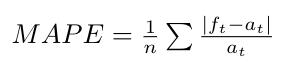

This metric is a percentage error. 

In [182]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [183]:
MAPE_test.append(mean_absolute_percentage_error(y_test, y_te_pred))
MAPE_train.append(mean_absolute_percentage_error(y_train, y_tr_pred))
mean_absolute_percentage_error(y_train, y_tr_pred), mean_absolute_percentage_error(y_test, y_te_pred)                 

(7.230818158899728, 8.03507166167836)

## 3.8 Scaling Test/Train<a id='3.8_Scaling Test/Train'></a>

Our data is on different scales. For example, square footage is in the thousands, while percentage of kids receiving school lunch is necessarily under 100. The dummy variables are either 0 or 1. Let's scale the features that are not binary. 

In [184]:
X_train.columns, X_test.columns

(Index(['sqft', 'percentFreeDiscLunch', 'percentofAfricanAmericanStudents',
        'percentofAsianStudents', 'percentofHispanicStudents',
        'percentofIndianStudents', 'percentofPacificIslanderStudents',
        'percentofTwoOrMoreRaceStudents', 'percentofWhiteStudents',
        'rankMovement', 'Median household income (in 2019 dollars), 2015-2019',
        'beds_3', 'beds_4', 'beds_5', 'baths_2', 'baths_3', 'baths_4'],
       dtype='object'),
 Index(['sqft', 'percentFreeDiscLunch', 'percentofAfricanAmericanStudents',
        'percentofAsianStudents', 'percentofHispanicStudents',
        'percentofIndianStudents', 'percentofPacificIslanderStudents',
        'percentofTwoOrMoreRaceStudents', 'percentofWhiteStudents',
        'rankMovement', 'Median household income (in 2019 dollars), 2015-2019',
        'beds_3', 'beds_4', 'beds_5', 'baths_2', 'baths_3', 'baths_4'],
       dtype='object'))

In [185]:
#Call the StandardScaler`s fit method on `X_train` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_train` and `X_test`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
col_list = ['sqft', 'percentFreeDiscLunch','percentofAfricanAmericanStudents',
       'percentofAsianStudents', 'percentofHispanicStudents',
       'percentofIndianStudents', 'percentofPacificIslanderStudents',
       'percentofTwoOrMoreRaceStudents', 'percentofWhiteStudents',
       'rankMovement', 'Median household income (in 2019 dollars), 2015-2019']
scaled_features = X_train.copy()
features = scaled_features[col_list]
scaler.fit(features.values)
features = scaler.transform(features.values)

In [186]:
# transform back to df
scaled_features[col_list] = features
X_tr_scaled = scaled_features.copy()

In [187]:
# transform test set
scaled_te_features = X_test.copy()
features = scaled_te_features[col_list]
features = scaler.transform(features.values)
scaled_te_features[col_list] = features
X_te_scaled = scaled_te_features.copy()

In [188]:
X_tr_scaled.columns, X_te_scaled.columns

(Index(['sqft', 'percentFreeDiscLunch', 'percentofAfricanAmericanStudents',
        'percentofAsianStudents', 'percentofHispanicStudents',
        'percentofIndianStudents', 'percentofPacificIslanderStudents',
        'percentofTwoOrMoreRaceStudents', 'percentofWhiteStudents',
        'rankMovement', 'Median household income (in 2019 dollars), 2015-2019',
        'beds_3', 'beds_4', 'beds_5', 'baths_2', 'baths_3', 'baths_4'],
       dtype='object'),
 Index(['sqft', 'percentFreeDiscLunch', 'percentofAfricanAmericanStudents',
        'percentofAsianStudents', 'percentofHispanicStudents',
        'percentofIndianStudents', 'percentofPacificIslanderStudents',
        'percentofTwoOrMoreRaceStudents', 'percentofWhiteStudents',
        'rankMovement', 'Median household income (in 2019 dollars), 2015-2019',
        'beds_3', 'beds_4', 'beds_5', 'baths_2', 'baths_3', 'baths_4'],
       dtype='object'))

## 3.9 Initial Model - Linear Regression<a id='3.9_Initial_Model_-_Linear_Regression'></a>

The first model we will run is the default Linear Regression model. We don't need to use the scaled data with Linear Regression (or, we can - it makes no difference). Let's use the unscaled data so that, if necessary, we can interpret the coefficients. 

In [189]:
# Instantiate the model and fit to training data
lm = LinearRegression().fit(X_tr_scaled, y_train)
print(X_tr_scaled.shape)
print(len(lm.coef_))

(246, 17)
17


##### 3.9.1 Make predictions using the model on both train and test splits

In [190]:
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [191]:
# r^2 - train, test
lm_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
lm_r2

(0.6694320138327788, 0.8541632189840455)

Here we see that our simple linear regression model explains almost 70% of the variance on the train set and 86% on the test set. This might be a luck of the draw. The model seems underfit. That's a lot of bias. 

In [192]:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(104.93570628628994, 68.94947728788478)

In [193]:
models.append(('LR', lm))
mae_test.append(mean_absolute_error(y_test, y_te_pred))
mae_train.append(mean_absolute_error(y_train, y_tr_pred))
r2_test.append(r2_score(y_test, y_te_pred))
r2_train.append(r2_score(y_train, y_tr_pred))
MAPE_test.append(mean_absolute_percentage_error(y_test, y_te_pred))
MAPE_train.append(mean_absolute_percentage_error(y_train, y_tr_pred))

This is much better than simply using the mean as we did with the dummy regressor (MAE=192 on test set). Let's try to fit a hyperparameter, the number of features used. 

In [194]:
pipe = make_pipeline( 
    SelectKBest(f_regression),
    LinearRegression()
)

In [195]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_tr_scaled, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000011F33C58700>)),
                ('linearregression', LinearRegression())])

In [196]:
y_tr_pred = pipe.predict(X_tr_scaled)
y_te_pred = pipe.predict(X_te_scaled)

In [197]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6349763889511297, 0.8488555088632413)

In [198]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(111.77609517053844, 71.86325992329274)

In [199]:
models.append(('SelKBest=10', pipe))
mae_test.append(mean_absolute_error(y_test, y_te_pred))
mae_train.append(mean_absolute_error(y_train, y_tr_pred))
r2_test.append(r2_score(y_test, y_te_pred))
r2_train.append(r2_score(y_train, y_tr_pred))
MAPE_test.append(mean_absolute_percentage_error(y_test, y_te_pred))
MAPE_train.append(mean_absolute_percentage_error(y_train, y_tr_pred))

This improves upon the default linear regression model slightly. There is no overfitting here. The default number of *k* is 10. Perhaps we can do better after checking the best value for k. 

In [200]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [201]:
# build grid of hyperparameters
k = [k+1 for k in range(len(X_tr_scaled.columns))]
grid_params = {'selectkbest__k': k}
print(grid_params)

{'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}


In [202]:
# We can use GridSearchCV because linear regression is very fast and we're only checking one parameter
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=10, n_jobs=-1)

In [203]:
# fit the model with cv=10
lr_grid_cv.fit(X_tr_scaled, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000011F33C58700>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17]})

In [204]:
y_tr_pred = lr_grid_cv.predict(X_tr_scaled)
y_te_pred = lr_grid_cv.predict(X_te_scaled)

In [205]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6691394462065974, 0.8564394053487611)

In [206]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(104.98100096722503, 68.25861095680176)

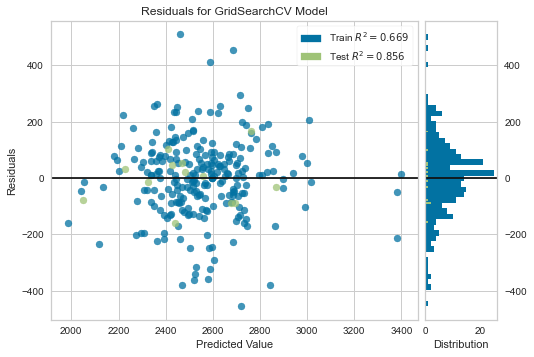

<AxesSubplot:title={'center':'Residuals for GridSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [207]:
visualizer = ResidualsPlot(lr_grid_cv)

visualizer.fit(X_tr_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_te_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  

In [208]:
models.append(('LR optimized', lr_grid_cv))
mae_test.append(mean_absolute_error(y_test, y_te_pred))
mae_train.append(mean_absolute_error(y_train, y_tr_pred))
r2_test.append(r2_score(y_test, y_te_pred))
r2_train.append(r2_score(y_train, y_tr_pred))
MAPE_test.append(mean_absolute_percentage_error(y_test, y_te_pred))
MAPE_train.append(mean_absolute_percentage_error(y_train, y_tr_pred))

In [209]:
# Find the best scores
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [210]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 15}

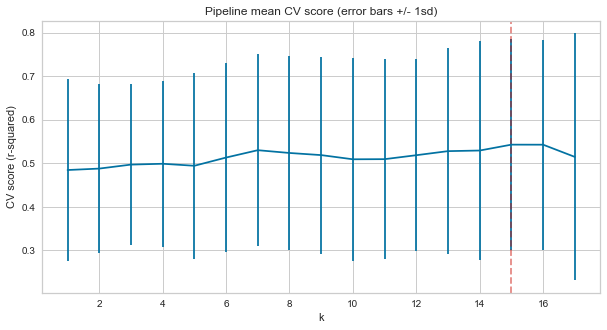

In [211]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [212]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
print(selected)

[ True  True  True False  True  True  True False  True  True  True  True
  True  True  True  True  True]


In [213]:
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_tr_scaled.columns[selected]
lr_coefs = pd.Series(coefs, index=features).sort_values(ascending=False)

In [214]:
lr_coefs

baths_3                                                 306.811373
baths_4                                                 292.134974
baths_2                                                 257.727317
percentFreeDiscLunch                                    212.573128
sqft                                                    160.359256
beds_5                                                  118.763824
beds_4                                                  111.552239
beds_3                                                   82.316945
Median household income (in 2019 dollars), 2015-2019     35.977315
rankMovement                                             -2.887222
percentofIndianStudents                                 -15.919399
percentofPacificIslanderStudents                        -57.582656
percentofAfricanAmericanStudents                        -64.599767
percentofWhiteStudents                                  -72.424285
percentofHispanicStudents                              -226.73

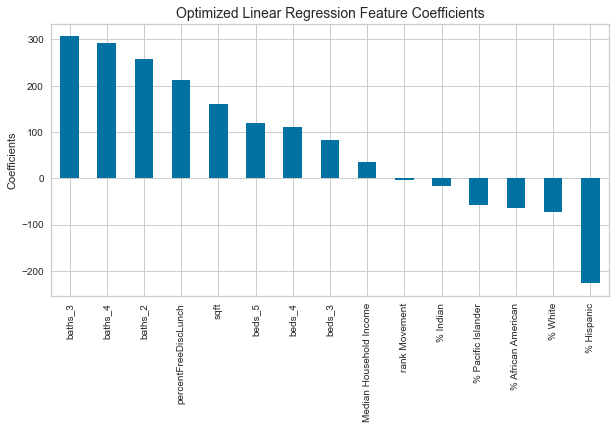

In [215]:
ticks = ['baths_3', 'baths_4', 'baths_2', 'percentFreeDiscLunch', 'sqft',
         'beds_5', 'beds_4', 'beds_3', 'Median Household Income', 'rank Movement', 
         '% Indian', '% Pacific Islander', '% African American', '% White',
         '% Hispanic']
figure, ax = plt.subplots(figsize=(10, 5))
lr_coefs.plot(kind='bar', ax=ax)
ax.set_ylabel('Coefficients')
ax.set_title('Features')
ax.set_xticklabels(ticks)
plt.title('Optimized Linear Regression Feature Coefficients', fontsize=14)
plt.show()

This is unexpected. This shows that really, people are willing to pay more for bathrooms. Anything over 1 bathroom commands a premium. The value of the house and the square footage don't seem to matter much. The median household income of the city also doesn't seem to matter! 

## 3.10 Ridge model <a id='4.10_LASSO_model'></a>

Linear regression worked better than the dummy regressor (mean). But our coefficients are very high. Ridge regression is a type of regularization which reduces the coefficients of the features (but never to zero). 

In [216]:
from sklearn.linear_model import Ridge
ridgem = Ridge(alpha=0.05, normalize=True)
ridgem.fit(X_tr_scaled, y_train)
y_te_pred = ridgem.predict(X_te_scaled)
y_tr_pred = ridgem.predict(X_tr_scaled)

In [217]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6560260438181813, 0.8556016689334155)

In [218]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(106.8931160395097, 69.90026078917823)

In [219]:
models.append(('Ridge', ridgem))
mae_test.append(mean_absolute_error(y_test, y_te_pred))
mae_train.append(mean_absolute_error(y_train, y_tr_pred))
r2_test.append(r2_score(y_test, y_te_pred))
r2_train.append(r2_score(y_train, y_tr_pred))
MAPE_test.append(mean_absolute_percentage_error(y_test, y_te_pred))
MAPE_train.append(mean_absolute_percentage_error(y_train, y_tr_pred))

In [220]:
ridgem.coef_

array([152.90298112,  10.09246812, -26.35269064,   6.15121176,
       -18.27092888,  26.34738489,  -8.01323731,  -3.48306291,
        26.75186679, -14.54132768,  27.78471149,  49.9078998 ,
        89.84921059, 101.5401785 ,  98.0589864 , 145.15006092,
       135.9263215 ])

## 3.10 Lasso model <a id='4.10_LASSO_model'></a>

Lasso is another form of regularization which seeks to minimize lamba multiplied by the magnitude of the sum of the coefficients. In this method, some of the coefficients will go to zero, which can help with feature selection. We have a lot of features with very low coefficients in the linear regression model, those features may simply not be important. 

In [221]:
from sklearn.linear_model import Lasso
lassoReg = Lasso(max_iter=10000)

In [222]:
# Try default lasso
lassoReg.fit(X_tr_scaled, y_train)

y_tr_pred = lassoReg.predict(X_tr_scaled)
y_te_pred = lassoReg.predict(X_te_scaled)

In [223]:
# r2 of default lasso
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.654083208642541, 0.8661046250743178)

In [224]:
# MAE of default lasso
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(107.22658250421219, 65.40438600579455)

In [225]:
# what can we optimize with a lasso model?
lassoReg.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [226]:
# Set up grid for search
grid_params = {'alpha': arange(0,1,.01),
             'normalize': [True, False],
             'max_iter': [100000]
             }

lasso_grid_cv = GridSearchCV(lassoReg, param_grid=grid_params, cv=5, n_jobs=-1)

In [227]:
lasso_grid_cv.fit(X_tr_scaled, y_train)
lasso_grid_cv.best_params_, lasso_grid_cv.best_score_


({'alpha': 0.04, 'max_iter': 100000, 'normalize': True}, 0.6244933027568365)

In [228]:
y_tr_pred = lasso_grid_cv.predict(X_tr_scaled)
y_te_pred = lasso_grid_cv.predict(X_te_scaled)

In [229]:
Optlasso = Lasso(alpha=0.04, max_iter=100000, normalize=True)
Optlasso.fit(X_tr_scaled, y_train)
y_tr_pred_opt = Optlasso.predict(X_tr_scaled)
y_te_pred_opt = Optlasso.predict(X_te_scaled)

In [230]:
r2_score(y_train, y_tr_pred_opt), r2_score(y_test, y_te_pred_opt)

(0.6657159274198496, 0.8608623074157429)

In [231]:
mean_absolute_error(y_train, y_tr_pred_opt), mean_absolute_error(y_test, y_te_pred_opt)

(105.21152397515952, 67.50220820639707)

The optimized Lasso estimator has slightly better R2 and MAE than the default. We will save those to our list. 

In [232]:
models.append(('Optlasso', Optlasso))
mae_test.append(mean_absolute_error(y_test, y_te_pred_opt))
mae_train.append(mean_absolute_error(y_train, y_tr_pred_opt))
r2_test.append(r2_score(y_test, y_te_pred_opt))
r2_train.append(r2_score(y_train, y_tr_pred_opt))
MAPE_test.append(mean_absolute_percentage_error(y_test, y_te_pred))
MAPE_train.append(mean_absolute_percentage_error(y_train, y_tr_pred))

In [233]:
# What are the coefficients of the Lasso model
Optlasso.coef_

array([160.36090046,   0.        , -32.07603604,   0.        ,
       -21.95292927,  33.73013696,  -8.80003441,  -0.        ,
        12.35888395, -15.88357218,  28.0989266 ,  67.60828279,
       101.03950986, 112.1160115 , 226.0899765 , 271.76082336,
       261.99504369])

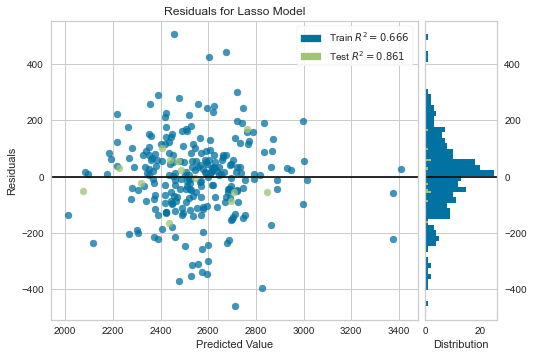

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [234]:
visualizer = ResidualsPlot(Optlasso)

visualizer.fit(X_tr_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_te_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  

Text(0.5, 1.0, 'Optimized Lasso feature coefficients')

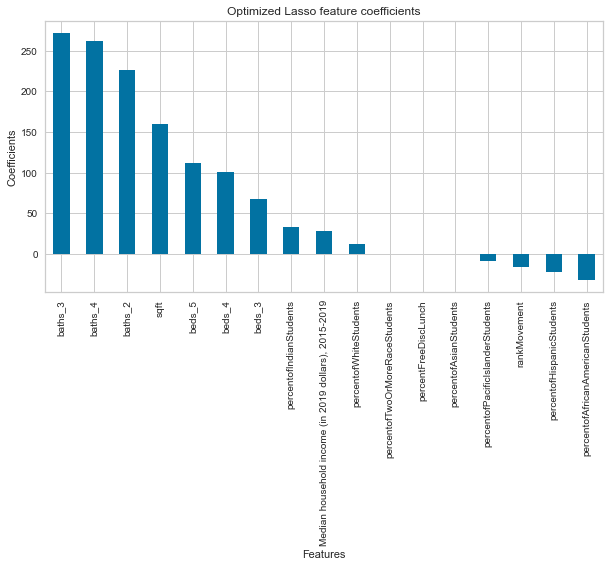

In [235]:
plt.subplots(figsize=(10, 5))
imps = Optlasso.coef_
ol_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
ol_feat_imps.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Optimized Lasso feature coefficients')

## 3.11 Random Forest Model<a id='4.10_Random_Forest_Model'></a>

First, let's try Random Forest Regressor with default hyperparameters, using the scaled data which include the 'value' feature. 


In [236]:
# Instantiate the model and fit it to scaled training data
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_tr_scaled, y_train)

RandomForestRegressor(random_state=42)

In [237]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(rf_default, X_tr_scaled, y_train, cv=5)

In [238]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.61599887, 0.50851343, 0.59538351, 0.4782765 , 0.60426942])

In [239]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.5604883459044357, 0.05599295097634886)

## 3.12 Hyperparameter search using RandomSearchCV<a id='4.10_Random_Forest_Model'></a>

Let's try some hyperparameters and see if we can improve upon the default random forest regressor. 

In [240]:
# Build param grid for random search
n_est = [10, 50, 100, 500, 1000, 1200, 1500]
max_features = ['auto', 'sqrt']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
min_samples_split = [2, 5, 10, 15, 20, 25, 30, 35, 40]
min_samples_leaf = [2, 5, 10, 15, 20]

random_grid = {
        'bootstrap': [True, False],
        'n_estimators': n_est,
        'max_depth': max_depth,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'criterion': ["mse", "mae"]
}
random_grid

{'bootstrap': [True, False],
 'n_estimators': [10, 50, 100, 500, 1000, 1200, 1500],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40],
 'min_samples_leaf': [2, 5, 10, 15, 20],
 'criterion': ['mse', 'mae']}

In [241]:
# Call RandomizedSearchCV with RandomForestRegressor, the random_grid, and cv=5
rf = RandomForestRegressor(random_state=42)
rf_random_cv = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                                  cv=5, n_jobs=-1)

In [242]:
#Now call the `RandomizedSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_random_cv.fit(X_tr_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10, 15, 20],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25, 30, 35, 40],
                                        'n_estimators': [10, 50, 100, 500, 1000,
                                                         1200, 1500]})

In [243]:
#Print the best params (`best_params_` attribute) from the grid search
rf_random_cv.best_params_

{'n_estimators': 1500,
 'min_samples_split': 35,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'criterion': 'mae',
 'bootstrap': True}

In [244]:
rf_best_cv_results = cross_validate(rf_random_cv.best_estimator_, X_tr_scaled, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.66038298, 0.5120526 , 0.45826059, 0.42047515, 0.52869222])

In [245]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.5159727092322595, 0.08183147511213489)

With the hyperparameters, we have improved upon the default Cross-Validation scores (which were (0.5083582011930894, 0.1903526257700541) - but, not by very much. 

Text(0.5, 1.0, 'Best random forest regressor feature importances')

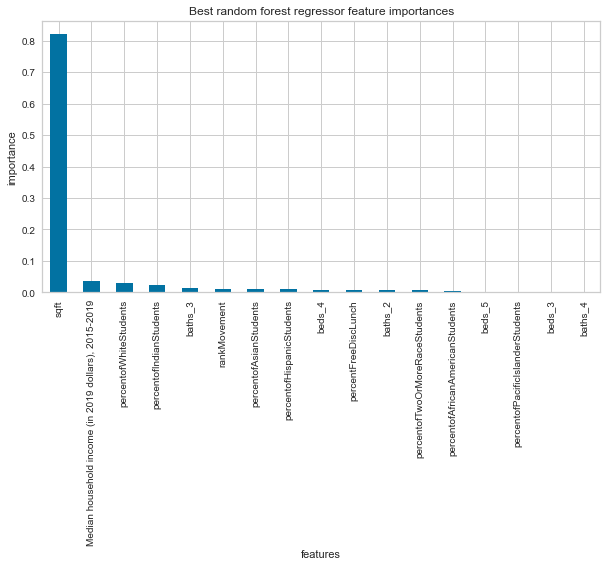

In [246]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_random_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_random_cv.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_tr_scaled.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances')

Strangely - this model values square footage and value of the property over all else. it also likes 3 baths, certain racial demographics (?) and is positively affected by median household income and an improving school district. 

## 3.13 Metrics - Comparing models<a id='4.10_Random_Forest_Model'></a>

#### 3.13.1 Linear Regression - Lasso Optimized Model Performance

In [247]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
Optlasso_neg_mae = cross_validate(Optlasso, X_tr_scaled, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [248]:
Optlasso_mae_mean = np.mean(-1 * Optlasso_neg_mae['test_score'])
Optlasso_mae_std = np.std(-1 * Optlasso_neg_mae['test_score'])
Optlasso_mae_mean, Optlasso_mae_std

(111.28670348356215, 11.466391987801867)

In [249]:
mean_absolute_error(y_test, Optlasso.predict(X_te_scaled)), mean_absolute_error(y_train, Optlasso.predict(X_tr_scaled))

(67.50220820639707, 105.21152397515952)

In [250]:
std_from_estimate = (mean_absolute_error(y_test, Optlasso.predict(X_te_scaled)) - Optlasso_mae_mean)/Optlasso_mae_std
std_from_estimate

-3.818506756418561

#### 3.13.2 Random Forest Model Performance

In [251]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
rf_neg_mae = cross_validate(rf_random_cv.best_estimator_, X_tr_scaled, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [252]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std
y_te_pred = rf_random_cv.best_estimator_.predict(X_te_scaled)

In [253]:
mean_absolute_error(y_test, y_te_pred), mean_absolute_error(y_train, rf_random_cv.best_estimator_.predict(X_tr_scaled))

(101.43976923076924, 105.62936178861789)

In [254]:
models.append(('RF-Optimized', rf_random_cv))
mae_test.append(mean_absolute_error(y_test, y_te_pred))
mae_train.append(mean_absolute_error(y_train, y_tr_pred))
r2_test.append(r2_score(y_test, y_te_pred))
r2_train.append(r2_score(y_train, y_tr_pred))
MAPE_test.append(mean_absolute_percentage_error(y_test, y_te_pred))
MAPE_train.append(mean_absolute_percentage_error(y_train, y_tr_pred))

In [255]:
std_from_estimate = (mean_absolute_error(y_test, rf_random_cv.best_estimator_.predict(X_te_scaled)) - rf_mae_mean)/rf_mae_std
std_from_estimate

-1.6756511202458786

In [256]:
# Create a df of the metrics
metrics = pd.DataFrame()
metrics['model'] = models
metrics['r2_test'] = r2_test
metrics['r2_train'] = r2_train
metrics['MAPE_test'] = MAPE_test
metrics['MAPE_train'] = MAPE_train

In [257]:
metrics.sort_values(['MAPE_test', 'MAPE_train'])

,model,r2_test,r2_train,MAPE_test,MAPE_train
5,"(Optlasso, Lasso(alpha=0.04, max_iter=100000, ...",0.860862,0.665716,2.683370,4.167345
3,"(LR optimized, GridSearchCV(cv=10,\n ...",0.856439,0.669139,2.724822,4.159289
1,"(LR, LinearRegression())",0.854163,0.669432,2.755728,4.157378
4,"(Ridge, Ridge(alpha=0.05, normalize=True))",0.855602,0.656026,2.793839,4.244363
2,"(SelKBest=10, (SelectKBest(score_func=<functio...",0.848856,0.634976,2.909747,4.439860
6,"(RF-Optimized, RandomizedSearchCV(cv=5, estima...",0.743929,0.665716,4.103208,4.167345
0,"(DR, DummyRegressor())",-0.072249,0.000000,8.035072,7.230818


#### 3.13.3 Conclusion

In all, we tried:
-  Dummy Regressor (mean)
-  Linear Regression with selectKBest
-  Ridge Regression
-  Lasso and a Lasso with optimized hyperparameters
-  Random forest and a random forest with optimized hyperparameters


The best model for the data we have is an optimized Linear Regression based on lowest MAPE on test set. 
The following charts show the MAPE and R2 for the various models we have tried in this notebook. 

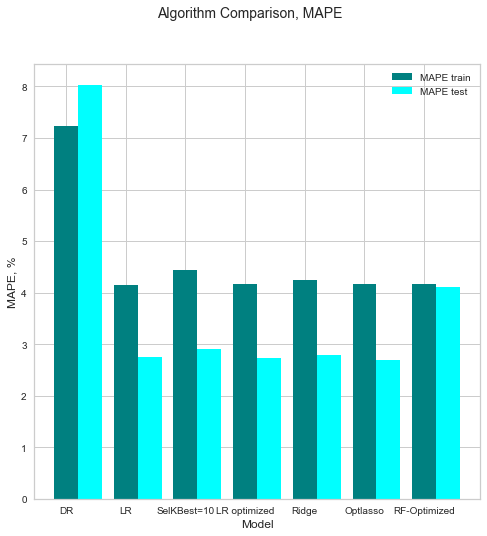

In [258]:
names = []
for name, model in models:
    names.append(name)

bar_width=0.4
X_axis = np.arange(len(names))
fig, ax = plt.subplots(figsize=(8, 8))
MAPE_tr = ax.bar(X_axis, MAPE_train, label='MAPE train', color='teal', width=bar_width)
MAPE_te = ax.bar(X_axis + bar_width, MAPE_test, label='MAPE test', color='aqua', width=bar_width)

fig.suptitle('Algorithm Comparison, MAPE', fontsize=14)
plt.xticks(X_axis, names)
plt.ylabel("MAPE, %", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.legend()
plt.show()


<Figure size 576x396 with 0 Axes>

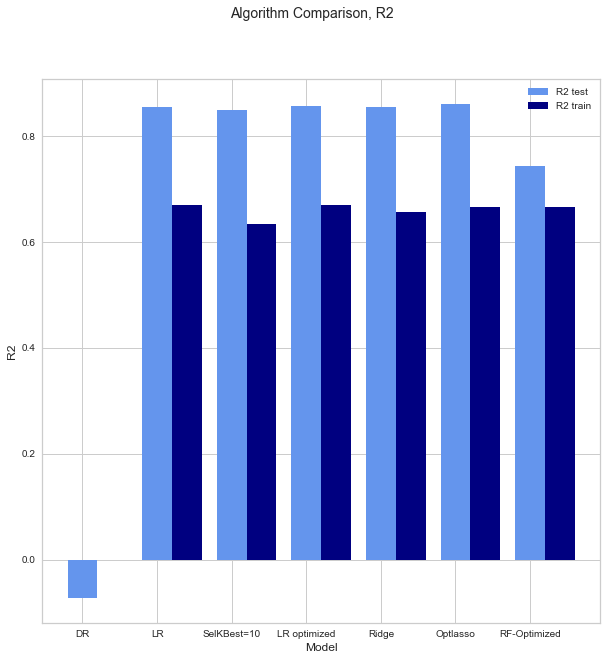

In [259]:
plt.clf()
bar_width=.4
X_axis = np.arange(len(names))
fig, ax = plt.subplots(figsize=(10,10))
r2_te = ax.bar(X_axis, r2_test, label='R2 test', color='cornflowerblue', width=bar_width)
r2_tr = ax.bar(X_axis + bar_width, r2_train, label='R2 train', color='navy', width=bar_width)
plt.xticks(X_axis, names)
plt.legend()
fig.suptitle('Algorithm Comparison, R2', fontsize=14)
plt.ylabel("R2", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.show()

The optimized Linear Regression model has the best score using MAPE on the test set. 

## 3.14 Data quantity assessment<a id='4.12_Data_quantity_assessment'></a>

Finally, do we need to acquire more data? Would more data be useful? Gathering more data using the methods we have at our disposal takes time. Assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.

In [260]:
fractions = [.1, .2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(Optlasso, X_tr_scaled, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

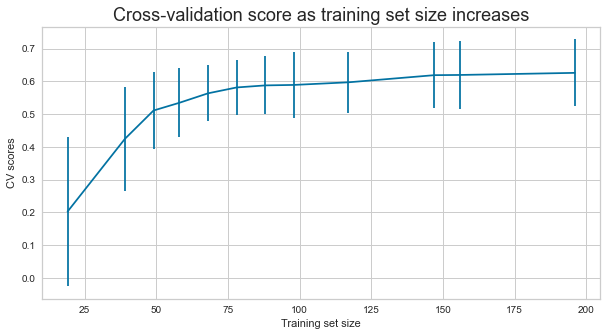

In [261]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases', fontsize=18);

It looks like we are past the elbow, but it would continue to benefit the model to collect new data. 

## 3.15 Save best model object from pipeline<a id='4.13_Save_best_model_object_from_pipeline'></a>

In [262]:
#Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute,
#the numpy version (`np.__version__`) to the `numpy_version` attribute,
#the sklearn version (`sklearn_version`) to the `sklearn_version` attribute,
#and the current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute
#Let's call this model version '1.0'
best_model = Optlasso
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [263]:
# save the model
modelpath = '../models'
save_file(best_model, 'market_rent_model.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../models\market_rent_model.pkl"
